# Probability of Default Data Validation 

## 1. Introduction

TBC

## 2. Setup

### Import Libraries

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
%matplotlib inline

## 3. Data Collection

In [11]:
import pandas as pd
import gzip

# Read the CSV file using pandas
filepath = '/Users/juanvalidmind/Dev/github/validmind/validmind-python/notebooks/datasets/probability_of_default/loan_data_2007_2014.csv'
df = pd.read_csv(filepath)

# Compress the DataFrame and save it as a gzip file
# df.to_csv('compressed_loan_data_2007_2014.csv.gz', compression='gzip', index=False)


## 4. Data Description

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_length                   445277 non-null  object 
 11  home_ownership               466285 non-null  object 
 12  annual_inc                   466281 non-null  float64
 13 

### 4.2.3. Data Preparation

#### Format Dates

For all columns with dates convert them to datetime format, create a new column as a difference between model development date and the respective date feature and then drop the original feature.

In [15]:
'''
function to convert date columns to datetime format and
create a new column as a difference between today and the respective date
'''
def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / 
							np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(
		lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# function to remove 'months' string from the 'term' column and convert it to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

date_columns(df, 'earliest_cr_line')
date_columns(df, 'issue_d')
date_columns(df, 'last_pymnt_d')
date_columns(df, 'last_credit_pull_d')

#### Format Variables

Remove text from the `emp_length` column (e.g., years) and convert it to numeric.

In [7]:
# function to clean up the emp_length column, assign 0 to NANs, and convert to numeric
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

emp_length_converter(df, 'emp_length')

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_78524/1609628665.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\+ years', '')


Remove text from the `term` column and convert it to numeric.

In [16]:
# function to remove 'months' string from the 'term' column and convert it to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

loan_term_converter(df, 'term')

#### Missing Values

In [17]:
# drop columns with more than 80% null values
df.dropna(thresh = df.shape[0]*0.2, axis = 1, inplace = True)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 52 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             466285 non-null  int64  
 1   member_id                      466285 non-null  int64  
 2   loan_amnt                      466285 non-null  int64  
 3   funded_amnt                    466285 non-null  int64  
 4   funded_amnt_inv                466285 non-null  float64
 5   term                           466285 non-null  int64  
 6   int_rate                       466285 non-null  float64
 7   installment                    466285 non-null  float64
 8   grade                          466285 non-null  object 
 9   sub_grade                      466285 non-null  object 
 10  emp_length                     445277 non-null  object 
 11  home_ownership                 466285 non-null  object 
 12  annual_inc                    

#### Target Variable

Definition of Bad.

#### Outliers

*Methodology*

*Model Framework*

## 4.5. Training Data

### 4.5.1. Sampling

Splitting our data before any feature engineering prevents any data leakage from the test set to the training set and results in more accurate model evaluation.

#### Sampling Method

Split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset.

In [20]:
X = loan_data.drop('good_bad', axis = 1)
y = loan_data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)

## 4.6. Feature Engineering

In [59]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,inq_last_6mths,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim
456615,15000,15000,15000.0,8.90,476.30,80000.0,17.01,0.0,0.0,20699,59.0,32.0,0.00,16561.02000,1561.02,8940.22,143586.0,35100.0
451541,8000,8000,8000.0,18.25,204.24,44000.0,23.46,1.0,0.0,13245,32.1,25.0,5746.54,4697.52000,2444.06,204.24,180443.0,41300.0
394474,12150,12150,12100.0,18.92,314.65,27000.0,31.07,0.0,0.0,7172,73.2,22.0,9282.24,6293.00000,3425.24,314.65,34197.0,9800.0
110294,10000,10000,10000.0,6.03,304.36,33000.0,9.16,0.0,0.0,2138,21.2,17.0,0.00,10858.01000,858.01,3553.37,77959.0,10100.0
139343,15825,15825,15825.0,12.12,526.53,59000.0,17.94,0.0,0.0,30326,93.6,31.0,0.00,4736.52000,1301.35,526.53,187370.0,32400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163633,22800,22800,22800.0,16.29,557.98,85000.0,15.12,0.0,0.0,18556,67.5,22.0,12158.37,18968.20000,8326.57,557.98,29071.0,27500.0
399306,20275,20275,20175.0,12.49,678.18,48000.0,22.70,0.0,0.0,33997,75.0,20.0,9947.82,13563.60000,3236.42,678.18,186530.0,45300.0
57787,25000,25000,24975.0,14.30,585.61,65530.0,22.91,0.0,0.0,11848,68.1,24.0,0.00,30285.29598,5285.30,19162.85,290599.0,17400.0
81641,10000,10000,10000.0,15.10,347.15,50000.0,14.24,1.0,0.0,9693,65.1,9.0,2936.24,9373.05000,2309.29,347.15,27715.0,14900.0


### 4.5.1. Missing Values

In [51]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)

### 4.5.2. Feature Selection

We will perform feature selection to identify the most suitable features for our binary classification problem using the Chi-squared test for categorical features and ANOVA F-statistic for numerical features.

[]

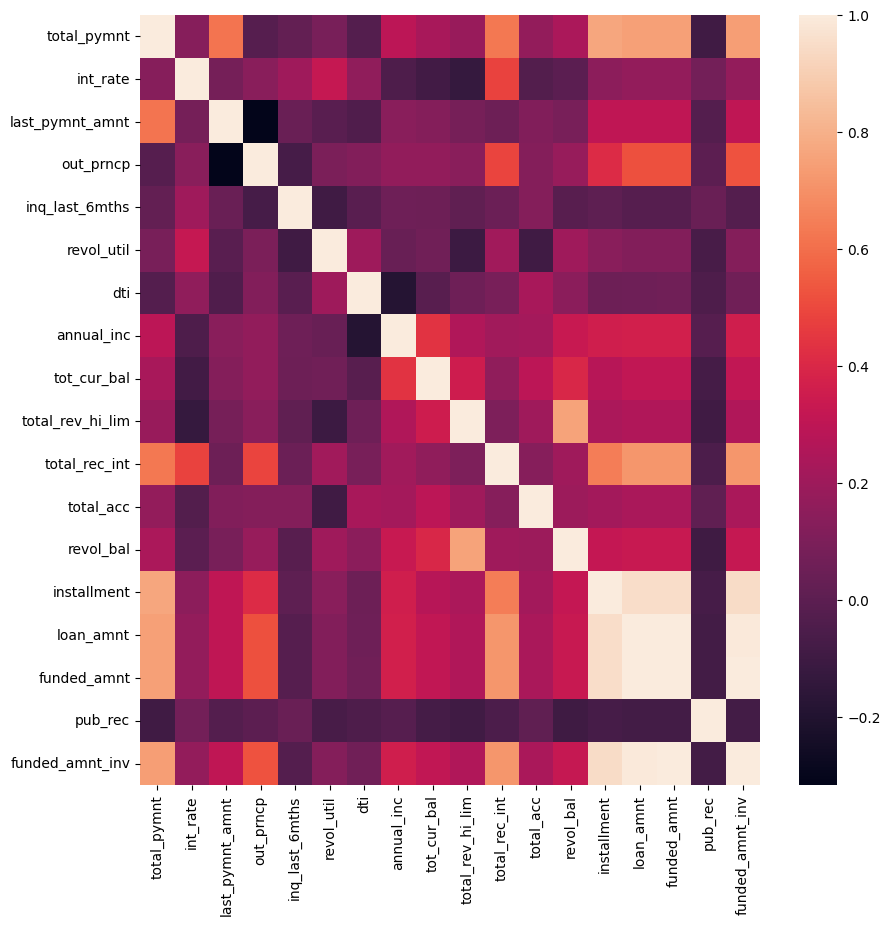

In [58]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)

# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,
					'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()

# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)

# save the names of columns to be dropped in a list
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list


In [ ]:
# function to drop these columns
def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)

### 4.5.3. Encoding of Categorical Variables

In [56]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our final four categorical variables
X_train.info()
# X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_amnt         373028 non-null  int64  
 1   funded_amnt       373028 non-null  int64  
 2   funded_amnt_inv   373028 non-null  float64
 3   term              373028 non-null  object 
 4   int_rate          373028 non-null  float64
 5   installment       373028 non-null  float64
 6   grade             373028 non-null  object 
 7   emp_length        356235 non-null  object 
 8   home_ownership    373028 non-null  object 
 9   annual_inc        373024 non-null  float64
 10  dti               373028 non-null  float64
 11  inq_last_6mths    373003 non-null  float64
 12  pub_rec           373003 non-null  float64
 13  revol_bal         373028 non-null  int64  
 14  revol_util        372764 non-null  float64
 15  total_acc         373003 non-null  float64
 16  out_prncp       

## 4.6. Model Selection

### 4.6.1. Model Selection Criteria

### 4.6.2. Model Analysis

## 4.7. Model Testing

TBC

## 4.8. Model Adjustments

TBC

# 5. Model Implementation

- Packages and dependencies
- Setup of model development
- Deployment to production infrastructure 
- Model execution and reporting 

# 6. Model Use

TBC

# 7. Ongoing Monitoring

TBC

# 8. Model Governance

TBC

##